In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/df-total/df_total_ref.parquet
/kaggle/input/week5/submission.csv
/kaggle/input/week5/train.csv
/kaggle/input/week5/test.csv
/kaggle/input/covid19/submission.csv
/kaggle/input/covid19/train.csv
/kaggle/input/covid19/test.csv


##### https://levelup.gitconnected.com/how-lightgbm-a-new-ai-framework-outperforms-xgboost-6044ea7b8281

##### https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

# IMPORT LIBRARIES

In [2]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as mpl
import lightgbm as lgb
import xgboost as xgb
import seaborn as sb
import plotly.express as px

from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,r2_score,mean_squared_error

-----

# 1)Read Dataset

In [3]:
df1_covid_train=pd.read_csv("/kaggle/input/covid19/train.csv")

df1_covid_test=pd.read_csv("/kaggle/input/covid19/test.csv")

In [4]:
display(df1_covid_train.shape)
display(df1_covid_test.shape)

display(df1_covid_train.head())
df1_covid_test.head()

(35995, 6)

(13459, 4)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


,ForecastId,Province_State,Country_Region,Date
0,1,NaN,Afghanistan,2020-04-02
1,2,NaN,Afghanistan,2020-04-03
2,3,NaN,Afghanistan,2020-04-04
3,4,NaN,Afghanistan,2020-04-05
4,5,NaN,Afghanistan,2020-04-06


In [5]:
display(df1_covid_train.info())
print("\n")
df1_covid_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35995 entries, 0 to 35994
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              35995 non-null  int64  
 1   Province_State  15295 non-null  object 
 2   Country_Region  35995 non-null  object 
 3   Date            35995 non-null  object 
 4   ConfirmedCases  35995 non-null  float64
 5   Fatalities      35995 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.6+ MB


None



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13459 entries, 0 to 13458
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ForecastId      13459 non-null  int64 
 1   Province_State  5719 non-null   object
 2   Country_Region  13459 non-null  object
 3   Date            13459 non-null  object
dtypes: int64(1), object(3)
memory usage: 420.7+ KB


### WHERE EACH COLUMN DESCRIBES THE FOLLOWING-:
- ID: Unique identifier
- Province_state: Provinces and states of a specific country, e.g. Washington in the United States
- Country_region: Countries as Germany, France or Spain
- Date: Datestamp for the respective row
- ConfirmedCases: The number of confirmed cases of Covid-19
- Fatalities: The number of registered deaths by Covid-19

### Inference-1= Mean cases observed during the period of time is 3684 on average.

# 2)EDA

### FOR SIMPLICITY

In [6]:
df1_covid_train.rename(columns={"Province_State":"State","Country_Region":"Country"},inplace=True)

df1_covid_test.rename(columns={"Province_State":"State","Country_Region":"Country"},inplace=True)

# 2) preprocesing

### 2A) MISSING VALUES

In [7]:
display(df1_covid_train.isna().sum())
print("\n")
# print(df1_covid[df1_covid.Province_State.isna()].shape)
df1_covid_train[df1_covid_train.State.isna()].head()


Id                    0
State             20700
Country               0
Date                  0
ConfirmedCases        0
Fatalities            0
dtype: int64

,Id,State,Country,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


### INFERENCE-1:we find that there are round 20,700 datapoints / countries whose individual State metric is not captured , but consolidated as a whole for each country.

## Addressing missing values

In [8]:
df1_work=df1_covid_train.fillna("NA")
display(df1_work.isna().sum())
print("\n")
(df1_work.head())



Id                0
State             0
Country           0
Date              0
ConfirmedCases    0
Fatalities        0
dtype: int64

,Id,State,Country,Date,ConfirmedCases,Fatalities
0,1,NA,Afghanistan,2020-01-22,0.0,0.0
1,2,NA,Afghanistan,2020-01-23,0.0,0.0
2,3,NA,Afghanistan,2020-01-24,0.0,0.0
3,4,NA,Afghanistan,2020-01-25,0.0,0.0
4,5,NA,Afghanistan,2020-01-26,0.0,0.0


In [9]:
"""Similar strategy employed for TEST DATA"""
df1_covid_test.fillna("NA",inplace=True)


In [10]:
df1_work_test=df1_covid_test.copy()

## 2B) converting object datatype TO Datatime column

In [11]:
df1_work.info()
print("\n")

df1_work.Date=pd.to_datetime(df1_work.Date,format="%Y/%m/%d").dt.date
print("After Conversion \n")
print("\n")

df1_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35995 entries, 0 to 35994
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              35995 non-null  int64  
 1   State           35995 non-null  object 
 2   Country         35995 non-null  object 
 3   Date            35995 non-null  object 
 4   ConfirmedCases  35995 non-null  float64
 5   Fatalities      35995 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.6+ MB


After Conversion 



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35995 entries, 0 to 35994
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              35995 non-null  int64  
 1   State           35995 non-null  object 
 2   Country         35995 non-null  object 
 3   Date            35995 non-null  object 
 4   ConfirmedCases  35995 non-null  float64
 5   Fatalities      359

### 2C).SETTING DATETIME COLUMN AS INDEX COLUMNN 

In [12]:
df1_work.set_index("Date",drop=True,inplace=True)
display(df1_work.info())
print("\n")
df1_work.head()

<class 'pandas.core.frame.DataFrame'>
Index: 35995 entries, 2020-01-22 to 2020-05-15
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              35995 non-null  int64  
 1   State           35995 non-null  object 
 2   Country         35995 non-null  object 
 3   ConfirmedCases  35995 non-null  float64
 4   Fatalities      35995 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.6+ MB


None

,Id,State,Country,ConfirmedCases,Fatalities
Date,,,,,
2020-01-22,1,NA,Afghanistan,0.0,0.0
2020-01-23,2,NA,Afghanistan,0.0,0.0
2020-01-24,3,NA,Afghanistan,0.0,0.0
2020-01-25,4,NA,Afghanistan,0.0,0.0
2020-01-26,5,NA,Afghanistan,0.0,0.0


In [13]:
df1_work.index[1]

datetime.date(2020, 1, 23)

In [14]:
"""START DATE & END DATE"""

start_date=df1_work.index.unique()[0]
end_date=df1_work.index.unique()[-1]

display(f'The data captures the global covid 19 cases between {start_date} and {end_date} & the trend of confirmed cases & fatalities have been rising.')


display(f'total no. of countries affected during the pandemic accounts to {df1_work.Country.nunique()}.')
display(f'total no. of days affected during the pandemic accounts to {df1_covid_train.Date.nunique()}.')
f'List of Countries encompassing in-State report are {df1_work.Country[df1_work.State!="NA"].unique()}'

'The data captures the global covid 19 cases between 2020-01-22 and 2020-05-15 & the trend of confirmed cases & fatalities have been rising.'

'total no. of countries affected during the pandemic accounts to 184.'

'total no. of days affected during the pandemic accounts to 115.'

"List of Countries encompassing in-State report are ['Australia' 'Canada' 'China' 'Denmark' 'France' 'Netherlands' 'US'\n 'United Kingdom']"

### 2D).Plotting Graphs 

In [15]:
confirmed_count=df1_work.groupby([df1_work.index,"Country"])["ConfirmedCases"].sum().reset_index()
display(confirmed_count.head())
fatality_count=df1_work.groupby([df1_work.index,"Country"])["Fatalities"].sum().reset_index()
fatality_count.head()


,Date,Country,ConfirmedCases
0,2020-01-22,Afghanistan,0.0
1,2020-01-22,Albania,0.0
2,2020-01-22,Algeria,0.0
3,2020-01-22,Andorra,0.0
4,2020-01-22,Angola,0.0


,Date,Country,Fatalities
0,2020-01-22,Afghanistan,0.0
1,2020-01-22,Albania,0.0
2,2020-01-22,Algeria,0.0
3,2020-01-22,Andorra,0.0
4,2020-01-22,Angola,0.0


In [16]:
display(px.bar(confirmed_count, x="Date", y="ConfirmedCases",color="Country"))

px.bar(fatality_count, x="Date", y="Fatalities",color="Country",color_continuous_scale="reds")

In [17]:
# try:
#     display(confirmed_count.sum())
#     fatality_count.sum()
# except:
#     print("")

## 2E).TREND(CONFIRMED CASES & FATALATIES) ACROSS TOP 10 COUNTRIES

### NOTE:-Performing inner join based on covid 19 cases for top 10 countries & merfging with the df_countries

In [18]:
trend_df_confirmed=confirmed_count.groupby(["Country"]).sum().nlargest(20,"ConfirmedCases")
trend_df_fatal=fatality_count.groupby(["Country"]).sum().nlargest(20,"Fatalities")

In [19]:
display(trend_df_confirmed)
trend_df_fatal

,ConfirmedCases
Country,
US,39749076.0
Italy,9386990.0
Spain,9322515.0
China,7946795.0
Germany,7080489.0
France,6749906.0
United Kingdom,6360259.0
Iran,4358781.0
Turkey,4179317.0


,Fatalities
Country,
US,2122579.0
Italy,1211456.0
Spain,995560.0
United Kingdom,933303.0
France,899572.0
China,333639.0
Iran,273392.0
Belgium,261746.0
Germany,229882.0


In [20]:
confirmed_count

,Date,Country,ConfirmedCases
0,2020-01-22,Afghanistan,0.0
1,2020-01-22,Albania,0.0
2,2020-01-22,Algeria,0.0
3,2020-01-22,Andorra,0.0
4,2020-01-22,Angola,0.0
...,...,...,...
21155,2020-05-15,Vietnam,314.0
21156,2020-05-15,West Bank and Gaza,375.0
21157,2020-05-15,Western Sahara,6.0
21158,2020-05-15,Zambia,654.0


In [21]:
"""TOP 10 TREND CONFIRMED CASES ['with DATE FOR EACH OF COUNTRIES'] """
top10_trend_confirmed=confirmed_count.merge(trend_df_confirmed,on="Country").drop(columns="ConfirmedCases_y").rename(columns={"ConfirmedCases_x":"ConfirmedCases"})
# display(top10_trend_confirmed)

print("\n")
"""TOP 10 TREND FATAL CASES ['with DATE FOR EACH OF COUNTRIES'] """

top10_trend_fatal=fatality_count.merge(trend_df_fatal,on="Country").drop(columns="Fatalities_y").rename(columns={"Fatalities_x":"Fatalities"})
# top10_trend_fatal

display(px.bar(top10_trend_confirmed, x="Date", y="ConfirmedCases",color="Country"))

px.bar(top10_trend_fatal, x="Date", y="Fatalities",color="Country")

### Supplementary

In [22]:
display(px.line(top10_trend_confirmed, x="Date", y="ConfirmedCases",color="Country"))

px.line(top10_trend_fatal, x="Date", y="Fatalities",color="Country")

In [23]:
top10_trend_confirmed["logbased_confirmed"]=np.log(top10_trend_confirmed.ConfirmedCases+1)
top10_trend_fatal["logbased_fatal"]=np.log(top10_trend_fatal.Fatalities+1)

display(px.line(top10_trend_confirmed, x="Date", y="logbased_confirmed",color="Country"))
px.line(top10_trend_fatal, x="Date", y="logbased_fatal",color="Country")

### 3)Geographical _insights

In [24]:
"""df444 is created o etxtract iso alpha value for corresponding countries in the top10 trend countries affected by covid"""
df444=px.data.gapminder()
df444.loc[df444.country=='United States','country']="US"


df444.rename(columns={"country":"Country"},inplace=True)


df444

df444.drop(columns=['continent', 'year', 'lifeExp', 'pop', 'gdpPercap', 'iso_num'],inplace=True)

df_map=top10_trend_confirmed.merge(df444,how="left",on="Country")

df_map

,Date,Country,ConfirmedCases,logbased_confirmed,iso_alpha
0,2020-01-22,Belgium,0.0,0.000000,BEL
1,2020-01-22,Belgium,0.0,0.000000,BEL
2,2020-01-22,Belgium,0.0,0.000000,BEL
3,2020-01-22,Belgium,0.0,0.000000,BEL
4,2020-01-22,Belgium,0.0,0.000000,BEL
...,...,...,...,...,...
26330,2020-05-15,United Kingdom,238004.0,12.380047,GBR
26331,2020-05-15,United Kingdom,238004.0,12.380047,GBR
26332,2020-05-15,United Kingdom,238004.0,12.380047,GBR
26333,2020-05-15,United Kingdom,238004.0,12.380047,GBR


One of `'equirectangular'`, `'mercator'`, `'orthographic'`, `'natural earth'`, `'kavrayskiy7'`, `'miller'`, `'robinson'`, `'eckert4'`,`'azimuthal equal area'`, `'azimuthal equidistant'`, `'conic equal area'`, `'conic conformal'`, `'conic equidistant'`, `'gnomonic'`,
    `'stereographic'`, `'mollweide'`, `'hammer'`, `'transverse mercator'`,
    `'albers usa'`, `'winkel tripel'`, `'aitoff'`, or `'sinusoidal'`Default
    depends on `scope`.

In [25]:
px.choropleth(df_map,locations="iso_alpha",color="ConfirmedCases",animation_frame=df_map.Date.astype("str"),hover_name="Country",hover_data=["ConfirmedCases"],color_continuous_scale="plasma",\
              projection="natural earth")

# 4) EDA+ Feature engineering

In [26]:
df1_work.reset_index(inplace=True)
df1_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35995 entries, 0 to 35994
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            35995 non-null  object 
 1   Id              35995 non-null  int64  
 2   State           35995 non-null  object 
 3   Country         35995 non-null  object 
 4   ConfirmedCases  35995 non-null  float64
 5   Fatalities      35995 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.6+ MB


## A) Addressing Data leak bet. Tain & test Set so as to discard overlap

NOTE: HERE WE USE "u" as ALIAS Dataframe to find & remove  the data leak  & make sure the dat column after converting it into object type its in STRING FORMAT ELSE IT WORN T WORK

In [27]:
u=df1_work.copy()
u["Date"]=u.Date.astype("str",)
u.info()

# df1_work

df1_work.drop(df1_work[df1_work.Date.astype("str")=="2020-05-15"].index,inplace=True)


df1_work.Date.astype("str")


data_leak = u.merge(df1_covid_test, how='inner', on='Date')['Date'].unique().tolist()
# data_leak.append('2020-04-01')
display(len(data_leak))
data_leak.sort()
print("Both data sets contain the following dates: {}".format(data_leak))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35995 entries, 0 to 35994
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            35995 non-null  object 
 1   Id              35995 non-null  int64  
 2   State           35995 non-null  object 
 3   Country         35995 non-null  object 
 4   ConfirmedCases  35995 non-null  float64
 5   Fatalities      35995 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.6+ MB


43

Both data sets contain the following dates: ['2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13', '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19', '2020-04-20', '2020-04-21', '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26', '2020-04-27', '2020-04-28', '2020-04-29', '2020-04-30', '2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04', '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08', '2020-05-09', '2020-05-10', '2020-05-11', '2020-05-12', '2020-05-13', '2020-05-14']


## B) CREATION OF WHOLE DATAFRAME ((Train_set) U (Test_Set)) entailing same structure & Imputation of MISSING VALUES POST MERGING.

In [28]:
train_df_fix = df1_work.loc[~df1_work['Date'].astype("str").isin(data_leak)]
df_all = pd.concat([train_df_fix, df1_covid_test], axis = 0, sort=False)

#filling up the "new" NAs which were created by the concat process
df_all['ConfirmedCases'].fillna(0, inplace=True)
df_all['Fatalities'].fillna(0, inplace=True)
df_all['Id'].fillna(-999, inplace=True)
df_all['ForecastId'].fillna(-999, inplace=True)

## C)Validation of  NON EXISTANCE OF DUPLICATES/ DATA LEAKS IN TRAIN  FOR THE ABOVE DATA LEAKAGE DATASET


In [29]:

df_all.isna().sum()
rain_df_fix=train_df_fix.copy()

rain_df_fix.head()

rain_df_fix[rain_df_fix.Date.astype(str)=='2020-03-31']["Country"].nunique()


184

In [30]:
x=top10_trend_confirmed.Country.value_counts()
display(len(x))
y=list(x.index)

20

In [31]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35682 entries, 0 to 13458
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            35682 non-null  object 
 1   Id              35682 non-null  float64
 2   State           35682 non-null  object 
 3   Country         35682 non-null  object 
 4   ConfirmedCases  35682 non-null  float64
 5   Fatalities      35682 non-null  float64
 6   ForecastId      35682 non-null  float64
dtypes: float64(4), object(3)
memory usage: 2.2+ MB


In [32]:
df_all["Date"]=df_all.Date.astype("str")

### IMP_NOTE-overcome minute nuances

Do you pd.read_csv()? I bet you do.When you import data into a Pandas DataFrame, Pandas by default tries to know the data types of each column.However, the columns with text are by default marked as Object datatype.💡But Object dtype have a much broader scope. They can not only include strings, but also any other data that Pandas doesn't understand.After Pandas 1.0 (now 1.1.2), there's a dedicated dtype to handle and work with text data, that is, String.🤔How is this important?When a column is Object type, it does not necessarily mean that all the values will be string.In fact, they can all be numbers, or a mixture of string, integers and floats.With this discrepancy present, you can not do any string operation on the column straightaway.Moreover, having dtype as Object will make it less clear to work with just text and exclude the non-text values.With the new String dtype, the values are explicitly treated as strings.So, now you can extract and manipulate on only the strings within the columns by explicitly telling Pandas the dtype to be 'String' and not 'Object'.💡Have you been using this new dtype?What other use cases can this be beneficial in?

### D)CREATION OF NEW FEATURES BASED ON CONFIRMEDCASES& FATALITIES

In [33]:
def create_features(df):
    le=LabelEncoder()
    df['Day_num'] = le.fit_transform(df['Date'])
    df['Date'] = pd.to_datetime(df['Date'])
    df['Day'] = df['Date'].dt.day
    df['Week'] = df['Date'].dt.week
    df['Month'] = df['Date'].dt.month
    #df['Year'] = df['Date'].dt.year
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    
#     for label in y:
#         df["Country"+'_'+str(label)]=np.where(df["Country"]==label,1,0)
        
    df['Country'] = le.fit_transform(df['Country'])
    country_dict = dict(zip(le.inverse_transform(df['Country']), df['Country'])) 
    
    df['State'] = le.fit_transform(df['State'])
    state_dict = dict(zip(le.inverse_transform(df['State']), df['State']))
    
    return df, country_dict, state_dict

In [34]:
le=LabelEncoder()
df_all,country_dict,state_dict=create_features(df_all)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [35]:
display(df_all.head())
df_all.info()

,Date,Id,State,Country,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Week,Month,DayOfWeek
0,2020-01-22,1.0,72,0,0.0,0.0,-999.0,0,22,4,1,2
1,2020-01-23,2.0,72,0,0.0,0.0,-999.0,1,23,4,1,3
2,2020-01-24,3.0,72,0,0.0,0.0,-999.0,2,24,4,1,4
3,2020-01-25,4.0,72,0,0.0,0.0,-999.0,3,25,4,1,5
4,2020-01-26,5.0,72,0,0.0,0.0,-999.0,4,26,4,1,6


<class 'pandas.core.frame.DataFrame'>
Int64Index: 35682 entries, 0 to 13458
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            35682 non-null  datetime64[ns]
 1   Id              35682 non-null  float64       
 2   State           35682 non-null  int64         
 3   Country         35682 non-null  int64         
 4   ConfirmedCases  35682 non-null  float64       
 5   Fatalities      35682 non-null  float64       
 6   ForecastId      35682 non-null  float64       
 7   Day_num         35682 non-null  int64         
 8   Day             35682 non-null  int64         
 9   Week            35682 non-null  int64         
 10  Month           35682 non-null  int64         
 11  DayOfWeek       35682 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(7)
memory usage: 3.5 MB


### E)CREATION OF LAGS & TRENDS FEATURES BASED ON CONFIRMEDCASES& FATALITIES

- Engineering a dataset is key to obtain good results. In this case we will apply 2 different transformations:
- Lag. Lags are a way to compute the previous value of a column, so that the lag 1 for ConfirmedCases would inform the this column from the previous day. The lag 3 of a feature X is simply:
-  FORMULA= Xlag3(t)=X(t−3)
- Trend. Transformig a column into its trend gives the natural tendency of this column, which is different from the raw value. The definition of trend I will apply is:
-  FORMULA =(X(t)−X(t−1))/X(t−1)
- The backlog of lags I'll apply is 14 days, while for trends is 7 days. For ConfirmedCases and Fatalities:

In [36]:
def lag_feature(df,target_col,lags_range):
    for lag in lags_range:
        lag_col = target_col + "_{}".format(lag)
        df[lag_col] = df.groupby(['Country','State'])[target_col].shift(lag, fill_value=0)
    return df

def trend_feature(df,target_col,trends_range):
    for trend in trends_range:
        trend_col = "Trend_" + target_col + "_{}".format(trend)
        df[trend_col] = (df.groupby(['Country','State'])[target_col].shift(0, fill_value=0) - df.groupby(['Country','State'])[target_col].shift(trend, fill_value=0))/ df.groupby(['Country','State'])[target_col].shift(trend, fill_value=0.0001)
    return df

Footnote: GROUPBY + MULTIPLE SUCCESSIVE COLUMN ORDER CHANGE ALL THE AGGREGATE OPERATION WILL BE PERFORMED & REFLECTED IN THE CONFIRMEDCASES COLUMN YOU RE OPERATING ON.

In [37]:
rain_df_fix=train_df_fix.copy()

rain_df_fix.head()

rain_df_fix[rain_df_fix.Date.astype(str)=='2020-03-31']["Country"].nunique()

RD1=rain_df_fix.groupby(["Date","Country"])["ConfirmedCases"].aggregate("sum").reset_index().sort_values(["Date","ConfirmedCases"],ascending=[True,False])
RD1
RD1.Date[0]
RD2=RD1.groupby(["Date"])["ConfirmedCases"].aggregate("sum").reset_index()
RD2
RD1[RD1.Date.astype(str)=="2020-02-22"]

,Date,Country,ConfirmedCases
5740,2020-02-22,China,77001.0
5751,2020-02-22,Diamond Princess,634.0
5794,2020-02-22,"Korea, South",433.0
5790,2020-02-22,Japan,122.0
5854,2020-02-22,Singapore,85.0
...,...,...,...
5882,2020-02-22,Venezuela,0.0
5884,2020-02-22,West Bank and Gaza,0.0
5885,2020-02-22,Western Sahara,0.0
5886,2020-02-22,Zambia,0.0


## F)"""MODIFIED BASED ON MODEL TO ELIMINATE CURSE OF DIMENSIONALITY & SPARSITY"""

In [38]:
df_all1=lag_feature(df_all.reset_index().drop(columns="index"),"ConfirmedCases",range(1,7))
df_all1=lag_feature(df_all1,"Fatalities",range(1,7))
df_all1=trend_feature(df_all1,"ConfirmedCases",range(1,5))
df_all1=trend_feature(df_all1,"Fatalities",range(1,5))
df_all1.replace([np.inf, -np.inf], 0, inplace=True)
df_all1.fillna(0, inplace=True)

In [39]:
df_all1

,Date,Id,State,Country,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Week,...,Fatalities_5,Fatalities_6,Trend_ConfirmedCases_1,Trend_ConfirmedCases_2,Trend_ConfirmedCases_3,Trend_ConfirmedCases_4,Trend_Fatalities_1,Trend_Fatalities_2,Trend_Fatalities_3,Trend_Fatalities_4
0,2020-01-22,1.0,72,0,0.0,0.0,-999.0,0,22,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-23,2.0,72,0,0.0,0.0,-999.0,1,23,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-24,3.0,72,0,0.0,0.0,-999.0,2,24,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-25,4.0,72,0,0.0,0.0,-999.0,3,25,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-26,5.0,72,0,0.0,0.0,-999.0,4,26,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35677,2020-05-10,-999.0,72,183,0.0,0.0,13455.0,109,10,19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35678,2020-05-11,-999.0,72,183,0.0,0.0,13456.0,110,11,20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35679,2020-05-12,-999.0,72,183,0.0,0.0,13457.0,111,12,20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35680,2020-05-13,-999.0,72,183,0.0,0.0,13458.0,112,13,20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 5)Perform Train-Test Split(BASED ON DATETIME)

In [40]:
total_df1=df_all1.copy()
total_df1["Date"]=pd.to_datetime(total_df1.Date,format="%Y/%m/%d")
total_df1.set_index("Date",inplace=True)
total_df1.head()
# total_df1.index[-1]-total_df1.index[0]

,Id,State,Country,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Week,Month,...,Fatalities_5,Fatalities_6,Trend_ConfirmedCases_1,Trend_ConfirmedCases_2,Trend_ConfirmedCases_3,Trend_ConfirmedCases_4,Trend_Fatalities_1,Trend_Fatalities_2,Trend_Fatalities_3,Trend_Fatalities_4
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,1.0,72,0,0.0,0.0,-999.0,0,22,4,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-23,2.0,72,0,0.0,0.0,-999.0,1,23,4,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,3.0,72,0,0.0,0.0,-999.0,2,24,4,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25,4.0,72,0,0.0,0.0,-999.0,3,25,4,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,5.0,72,0,0.0,0.0,-999.0,4,26,4,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
df_train=total_df1[total_df1.index<"2020-04-02"]
df_test=total_df1[total_df1.index >="2020-04-02"]

"""SHAPE & SIZE OF SUBSETS"""

display(total_df1.shape)
display(f'Train_shape{df_train.shape}')
f'Test_shape {df_test.shape}'

(35682, 31)

'Train_shape(22223, 31)'

'Test_shape (13459, 31)'

In [42]:
df_train_train=df_train[df_train.index<"2020-03-15"]
df_train_test=df_train[df_train.index>="2020-03-15"]

"""SHAPE & SIZE OF TRAIN & VALIDATION SETS"""

display(df_train_train.shape)

df_train_test.shape

(16589, 31)

(5634, 31)

In [43]:
# mpl.figure(figsize=(10,5))
# df_train_train.plot(y="ConfirmedCases",figsize=(15,8),color="green")
# df_train_train.plot(y="Fatalities",figsize=(15,8),color="red")

<AxesSubplot:xlabel='Date', ylabel='Count'>

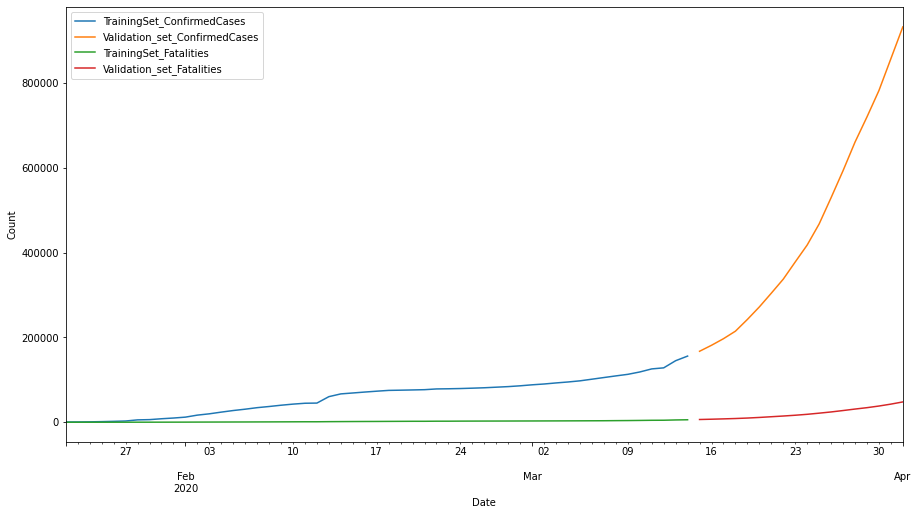

In [44]:
df_train_train_group_C=df_train_train.groupby([df_train_train.index,])["ConfirmedCases"].aggregate("sum")
df_train_test_group_C=df_train_test.groupby([df_train_test.index])["ConfirmedCases"].aggregate("sum")


df_train_train_group_C.plot(y="ConfirmedCases",figsize=(15,8),ylabel="Count",label="TrainingSet_ConfirmedCases",legend=True)
df_train_test_group_C.plot(y="ConfirmedCases",figsize=(15,8),label="Validation_set_ConfirmedCases",legend=True)


df_train_train_group_F=df_train_train.groupby([df_train_train.index,])["Fatalities"].aggregate("sum")
df_train_test_group_F=df_train_test.groupby([df_train_test.index])["Fatalities"].aggregate("sum")


df_train_train_group_F.plot(y="Fatalities",figsize=(15,8),ylabel="Count",label="TrainingSet_Fatalities",legend=True)
df_train_test_group_F.plot(y="Fatalities",figsize=(15,8),label="Validation_set_Fatalities",legend=True)


In [45]:
X_train=df_train_train.drop(columns=["ConfirmedCases"])
Y_train=df_train_train.ConfirmedCases

X_test=df_train_test.drop(columns=["ConfirmedCases"])
Y_test=df_train_test.ConfirmedCases



In [46]:
# ### a)GROUND TRUTH PLOTS FOR EACH COUNTRY & FOR CORRESPONDING strat_dat& end date based on unique DAY_NUMBER (LINEAR & LOGARITHMIC PLOTS)

# def gt_plots(df_all1,Country_name,start_day,end_day):

#     """CONVENTIONAL SCALE"""
#     y1 = df_all1[(df_all1['Country']==country_dict[Country_name]) & (df_all1['Day_num']>start_day) & (df_all1['Day_num']<=end_day)][['ConfirmedCases']]
#     x1 = range(0, len(y1))
#     mpl.figure(figsize=(15,8))
#     mpl.subplot(2,2,1)
#     mpl.plot(x1, y1, 'bo--')
#     mpl.title(f"{Country_name} ConfirmedCases between days {start_day} and {end_day}")
#     mpl.xlabel("Days")
#     mpl.ylabel("ConfirmedCases")
#     mpl.legend()

#     """LOG_SCALE"""

#     y2 = df_all1[(df_all1['Country']==country_dict[Country_name]) & (df_all1['Day_num']>start_day) & (df_all1['Day_num']<=end_day)][['ConfirmedCases']].apply(lambda x: np.log(x))
#     x2 = range(0, len(y2))
#     mpl.subplot(2,2,2)
#     mpl.plot(x2, y2, 'bo--',color="red")
#     mpl.title(f"{Country_name} ConfirmedCases between days {start_day} and {end_day}")
#     mpl.xlabel("Days")
#     mpl.ylabel("ConfirmedCases-LOG_SCALE")
#     mpl.legend()

    

# for i in range(1):
#     country_name=input("enter the country Name")
#     start_day=int(input("enter the start_day"))
#     end_day=int(input("enter the end_day"))
    
#     gt_plots(df_all1,country_name,start_day,end_day)

# 4) Applying ML MODELS

## XGBOOST MODEL

### Activates early stopping. Validation metric needs to improve at least once in every early_stopping_rounds round(s) to continue training.

In [47]:
def booster_function(boostertype,n_estimate,lr):
    reg=xgb.XGBRegressor(base_score=0.5, booster=boostertype,    
                       n_estimators=n_estimate,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=lr)
    reg.fit(X_train, Y_train,
            eval_set=[(X_train, Y_train), (X_test, Y_test)],
            verbose=100)
    display(reg.best_score)
    print(reg.best_iteration)
    reg.save_model(f'model+{boostertype}.json')
    
    
    """prediction"""
    y_pred=reg.predict(X_test)
#     len(y_pred)
    y_pred1=pd.DataFrame(y_pred,columns=["Prediction"])
    y_pred1
    """FORECAST"""
    Y_test1=Y_test.to_frame().reset_index()

    Y_test1["Prediction"]=y_pred1["Prediction"].copy()

    Y_test1.set_index("Date",inplace=True)
    display(Y_test1.head())
    Y_test1.plot(y=["ConfirmedCases","Prediction"],figsize=(10,8),color=["red","yellow"],title=f'pertaining to {boostertype}')
    Y_train.plot()

[22:01:11] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2867.88341	validation_1-rmse:7704.25479
[100]	validation_0-rmse:1107.33045	validation_1-rmse:3421.80028
[200]	validation_0-rmse:433.30108	validation_1-rmse:2321.43259
[300]	validation_0-rmse:172.49807	validation_1-rmse:2160.08888
[391]	validation_0-rmse:77.17601	validation_1-rmse:2157.61750


2151.9855339658166

342


,ConfirmedCases,Prediction
Date,,
2020-03-15,16.0,5.148778
2020-03-16,21.0,8.676394
2020-03-17,22.0,14.783799
2020-03-18,22.0,14.783799
2020-03-19,22.0,14.783799


[22:01:17] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[22:01:17] WARNING: ../src/learner.cc:627: 
Parameters: { "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:2555.76351	validation_1-rmse:6753.94084
[61]	validation_0-rmse:506.24829	validation_1-rmse:3238.41894


2826.136574383783

11


,ConfirmedCases,Prediction
Date,,
2020-03-15,16.0,71.411278
2020-03-16,21.0,65.689453
2020-03-17,22.0,68.991219
2020-03-18,22.0,72.167297
2020-03-19,22.0,75.295906


[22:01:17] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2867.88341	validation_1-rmse:7704.25479
[100]	validation_0-rmse:1107.33045	validation_1-rmse:3421.80028
[200]	validation_0-rmse:433.30108	validation_1-rmse:2321.43259
[300]	validation_0-rmse:172.49807	validation_1-rmse:2160.08888
[392]	validation_0-rmse:76.52728	validation_1-rmse:2157.65602


2151.9855339658166

342


,ConfirmedCases,Prediction
Date,,
2020-03-15,16.0,5.148779
2020-03-16,21.0,8.676394
2020-03-17,22.0,14.783800
2020-03-18,22.0,14.783800
2020-03-19,22.0,14.783800


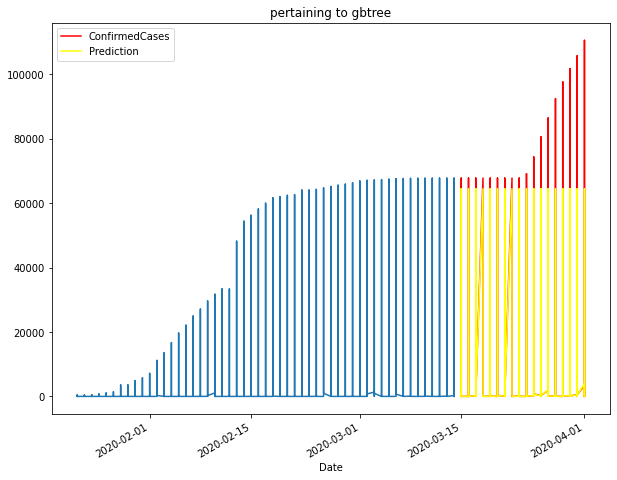

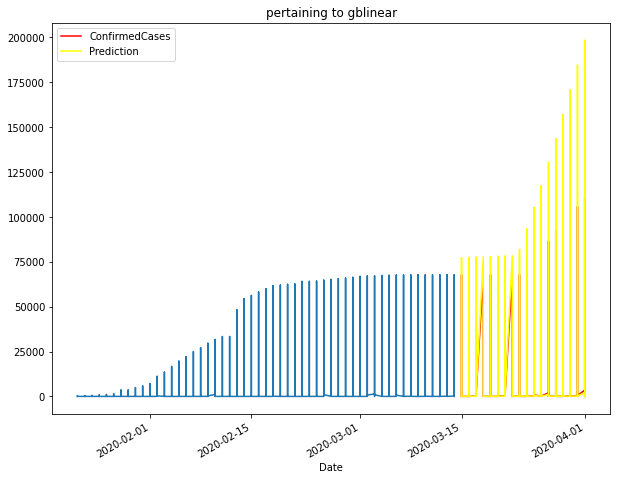

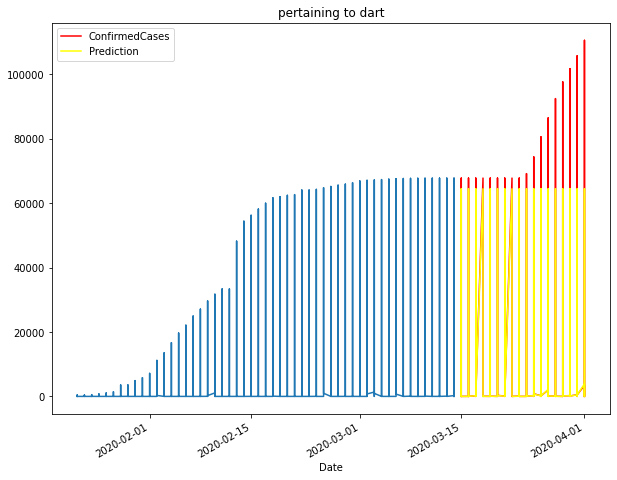

In [48]:
booster_function("gbtree",1000,0.01)
booster_function("gblinear",1000,0.01)
"""similr to gbtree but performs dropout of trees  after each layer to minimize/ prevent overfitting"""
booster_function("dart",1000,0.01)



In [49]:
XGB1=xgb.XGBRegressor()
XGB1.load_model("/kaggle/working/model+gbtree.json")

y2_pred=XGB1.predict(df_test.drop(columns=["ConfirmedCases"]))

In [50]:
len(df_test)
len(y2_pred)
df_test.head()
Y_test2=df_test.copy()
pd.DataFrame(y2_pred)

,0
0,229.884338
1,4.088952
2,4.088952
3,4.088952
4,4.088952
...,...
13454,4.088952
13455,4.088952
13456,4.088952
13457,4.088952


### NOTE: Recursively performed by varying Lags(7-14 days) to achieve optimal solution as above

---